# Import Libraries & Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
directory = 'data_PowerLaws_ForecastingEnergyConsumption/'

df_train = pd.read_csv(directory + 'train.csv', parse_dates=['Timestamp'])
df_holidays = pd.read_csv(directory + 'holidays.csv', parse_dates=['Date'])
df_metadata = pd.read_csv(directory + 'metadata.csv')
df_submission_format = pd.read_csv(directory + 'submission_format.csv')
df_submission_frequency = pd.read_csv(directory + 'submission_frequency.csv')
df_weather = pd.read_csv(directory + 'weather.csv', parse_dates=['Timestamp'])

# Inspect the Data 

## df_train

In [3]:
# inspect df_train
df_train.head()

,obs_id,SiteId,Timestamp,ForecastId,Value
0,744519,1,2014-09-03,1,9.096555e+05
1,7627564,1,2014-09-04,1,1.748273e+06
2,7034705,1,2014-09-05,1,NaN
3,5995486,1,2014-09-06,1,NaN
4,7326510,1,2014-09-07,1,NaN


In [4]:
# shape of df_train
# 6,559,830 rows in 'train.csv'
df_train.shape

(6559830, 5)

In [5]:
# info on df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6559830 entries, 0 to 6559829
Data columns (total 5 columns):
obs_id        int64
SiteId        int64
Timestamp     datetime64[ns]
ForecastId    int64
Value         float64
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 250.2 MB


In [6]:
# describe df_train
df_train.describe()

,obs_id,SiteId,ForecastId,Value
count,6.559830e+06,6.559830e+06,6.559830e+06,6.473229e+06
mean,3.935106e+06,1.620964e+02,3.482184e+03,3.560104e+05
std,2.271511e+06,9.392171e+01,2.009486e+03,3.309454e+08
min,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.968046e+06,8.700000e+01,1.744000e+03,3.492465e+03
50%,3.935262e+06,1.730000e+02,3.489000e+03,1.408683e+04
75%,5.901983e+06,2.370000e+02,5.216000e+03,4.649371e+04
max,7.869005e+06,3.050000e+02,6.974000e+03,6.404683e+11


In [7]:
# 86,601 NaN in 'Value'
df_train['Value'].isnull().value_counts()

False    6473229
True       86601
Name: Value, dtype: int64

In [8]:
# A forecast has either 964, 360, or 90 data point observations
# vast majority of ForecastId's have 964 data point observations 
df_train.ForecastId.value_counts().value_counts()

964    6750
360     121
90      103
Name: ForecastId, dtype: int64

In [9]:
# 267 SiteId within df_train
sites = df_train['SiteId'].unique()
sites.shape

(267,)

## df_holidays

* there are 110 unique holidays

In [10]:
# inspect df_holidays
df_holidays = df_holidays.drop('Unnamed: 0', axis=1)
df_holidays.head()

,Date,Holiday,SiteId
0,2016-01-01,New year,1
1,2016-01-18,"Birthday of Martin Luther King, Jr.",1
2,2016-02-15,Washington's Birthday,1
3,2016-05-30,Memorial Day,1
4,2016-07-04,Independence Day,1


In [11]:
# 8,387 holidays across all SiteId's in df_holidays
df_holidays.shape

(8387, 3)

In [12]:
# 110 unique holidays 
df_holidays['Holiday'].unique().size

110

In [13]:
# 227 SiteId's have 1 or more holidays in df_holidays
df_holidays['SiteId'].unique().size

227

In [14]:
# create series of SiteIds in df_train that have holidays in df_holidays
# note: there are extranneous SiteIds in df_holidays not found in df_train
holidays_SiteIds = pd.Series(df_holidays['SiteId'].unique())
train_SiteIds = pd.Series(df_train['SiteId'].unique())
train_SiteIds_with_holidays = holidays_SiteIds[holidays_SiteIds.isin(train_SiteIds)]
train_SiteIds_with_holidays = train_SiteIds_with_holidays.reset_index().drop('index', axis=1).iloc[:,0]

In [15]:
# all 227 SiteId's in df_train have holidays (i.e. 0 extraneous SiteId's in df_holidays)
train_SiteIds_with_holidays.size

227

## df_metadata

* 267 unique sites
* 5, 10, 15, 30 minute Sampling periods

In [16]:
# inspect df_metadata
df_metadata.head()

,SiteId,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff
0,1,1387.205119,15.0,18.0,False,False,False,False,False,True,True
1,2,6098.278376,30.0,18.0,False,False,False,False,False,True,True
2,3,10556.293605,5.0,18.0,False,False,False,False,False,True,False
3,5,12541.181277,30.0,18.0,False,False,False,False,False,True,True
4,6,9150.195373,30.0,18.0,False,False,False,False,False,True,True


In [17]:
# view shape of df_metadata
df_metadata.shape

(267, 11)

In [18]:
# building Sampling value_counts
df_metadata.Sampling.value_counts()

15.0    212
5.0      27
10.0     15
30.0     13
Name: Sampling, dtype: int64

In [19]:
# cast dayIsDayOff dtypes as int
df_metadata['MondayIsDayOff'] = df_metadata['MondayIsDayOff'].astype(int)
df_metadata['TuesdayIsDayOff'] = df_metadata['TuesdayIsDayOff'].astype(int)
df_metadata['WednesdayIsDayOff'] = df_metadata['WednesdayIsDayOff'].astype(int)
df_metadata['ThursdayIsDayOff'] = df_metadata['ThursdayIsDayOff'].astype(int)
df_metadata['FridayIsDayOff'] = df_metadata['FridayIsDayOff'].astype(int)
df_metadata['SaturdayIsDayOff'] = df_metadata['SaturdayIsDayOff'].astype(int)
df_metadata['SundayIsDayOff'] = df_metadata['SundayIsDayOff'].astype(int)

In [20]:
df_metadata.head()

,SiteId,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff
0,1,1387.205119,15.0,18.0,0,0,0,0,0,1,1
1,2,6098.278376,30.0,18.0,0,0,0,0,0,1,1
2,3,10556.293605,5.0,18.0,0,0,0,0,0,1,0
3,5,12541.181277,30.0,18.0,0,0,0,0,0,1,1
4,6,9150.195373,30.0,18.0,0,0,0,0,0,1,1


## df_weather

In [21]:
# inspect df_submission_frequency
df_weather = df_weather.drop('Unnamed: 0', axis=1)
df_weather.head()

,Timestamp,Temperature,Distance,SiteId
0,2013-12-31 19:00:00,-7.2,24.889929,1
1,2013-12-31 19:00:00,-8.3,23.303097,1
2,2013-12-31 19:00:00,-7.8,20.952256,1
3,2013-12-31 19:00:00,-8.0,20.952256,1
4,2013-12-31 19:34:00,-8.1,16.610602,1


In [22]:
# inspect shape of weather data
df_weather.shape

(20017278, 4)

In [83]:
# 247 unique SiteIds present in the weather data
df_weather['SiteId'].unique().shape

(247,)

In [23]:
# describe df_submission_frequency
df_weather.describe()

,Temperature,Distance,SiteId
count,2.001728e+07,2.001728e+07,2.001728e+07
mean,1.526123e+01,1.608350e+01,1.667469e+02
std,8.193082e+00,8.592004e+00,9.612129e+01
min,-2.630000e+01,3.895802e-01,1.000000e+00
25%,9.400000e+00,7.648476e+00,8.600000e+01
50%,1.500000e+01,1.638792e+01,1.700000e+02
75%,2.100000e+01,2.395172e+01,2.620000e+02
max,4.600000e+01,2.997784e+01,3.040000e+02


In [24]:
# info of df_weather
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20017278 entries, 0 to 20017277
Data columns (total 4 columns):
Timestamp      datetime64[ns]
Temperature    float64
Distance       float64
SiteId         int64
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 610.9 MB


### Plot Weather by SiteId

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
# create series of SiteIds in df_train that have weather data in df_weather
# note: there are extranneous SiteIds in df_weather not found in df_train
weather_SiteIds = pd.Series(df_weather['SiteId'].unique())
train_SiteIds = pd.Series(df_train['SiteId'].unique())
train_SiteIds_with_weather = weather_SiteIds[weather_SiteIds.isin(train_SiteIds)]
train_SiteIds_with_weather = train_SiteIds_with_weather.reset_index().drop('index', axis=1).iloc[:,0]

In [27]:
# 215 SiteIds in df_train have weather data
train_SiteIds_with_weather.size

215

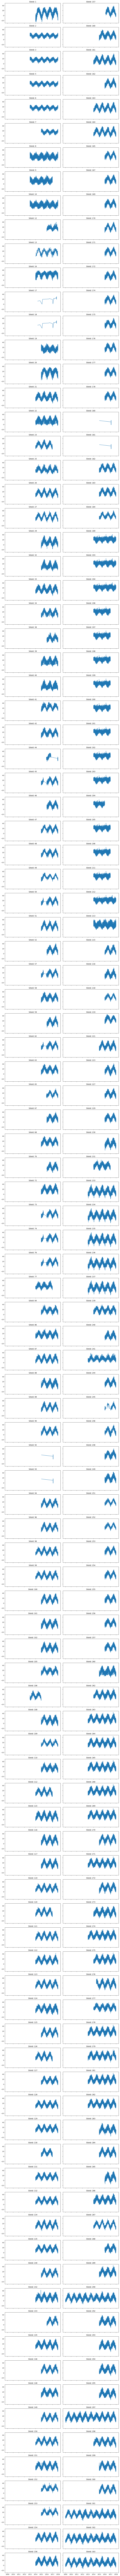

In [28]:
nrows = 107
ncols = 2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(12, 256), dpi=80, facecolor='w', edgecolor='k')

# n_plots = 10
for i in range(train_SiteIds_with_weather.size - 1):
    sid = train_SiteIds_with_weather.loc[i]
    mask = (df_weather['SiteId'] == sid)
    x = df_weather[mask].Timestamp
    y = df_weather[mask].Temperature
    
    if i < nrows:
        r, c = i, 0
    else:
        r, c = i-nrows, 1
    ax[r,c].plot(x,y)
    ax[r,c].set_title("SiteId: {}".format(sid));

plt.tight_layout()

### Identify Distribution of Timestamp by Minutes

* How to best resample at 15min intervals?

In [29]:
# add column for timestamp minute
df_weather['Minute'] = df_weather['Timestamp'].dt.minute
df_weather.head(2)

,Timestamp,Temperature,Distance,SiteId,Minute
0,2013-12-31 19:00:00,-7.2,24.889929,1,0
1,2013-12-31 19:00:00,-8.3,23.303097,1,0


In [31]:
# create dataframe to identify value_counts distribution of weather timestamps by minute
df_weather_min = pd.DataFrame(df_weather['Minute'].value_counts())
df_weather_min = df_weather_min.reset_index()
df_weather_min.columns = ['Minute', 'Count']
df_weather_min['PercentOf_Total'] = df_weather_min['Count'].apply(lambda x: x / df_weather_min['Count'].sum())
df_weather_min = df_weather_min.sort_values('PercentOf_Total', ascending=False)
df_weather_min.head()

,Minute,Count,PercentOf_Total
0,0,9111558,0.455185
1,50,4256344,0.212634
2,20,3565145,0.178103
3,30,1217190,0.060807
4,55,1057814,0.052845


In [32]:
# inspect df_weather_min
df_weather_min.shape

(60, 3)

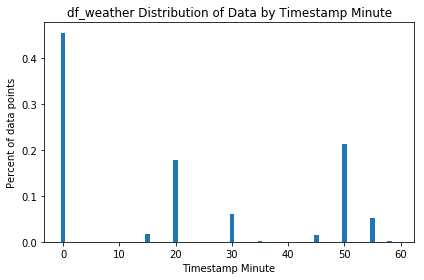

In [33]:
# plot df_weather_min for visual inspection of distribution by minute
plt.bar(df_weather_min['Minute'], df_weather_min['PercentOf_Total'])
plt.title('df_weather Distribution of Data by Timestamp Minute')
plt.ylabel('Percent of data points')
plt.xlabel('Timestamp Minute')
plt.tight_layout();

### Keep Nearest Temperature

In [34]:
# view first 5 datapoints for SiteId 1
df_weather[(df_weather['SiteId']==1)].head()

,Timestamp,Temperature,Distance,SiteId,Minute
0,2013-12-31 19:00:00,-7.2,24.889929,1,0
1,2013-12-31 19:00:00,-8.3,23.303097,1,0
2,2013-12-31 19:00:00,-7.8,20.952256,1,0
3,2013-12-31 19:00:00,-8.0,20.952256,1,0
4,2013-12-31 19:34:00,-8.1,16.610602,1,34


In [35]:
# create dataframe of nearest temperatures by SiteId and Timestamp
# inspect df_weather_nearest to compare above and see we took the nearest Temperature
df_weather_nearest = (df_weather.sort_values(['SiteId', 'Timestamp', 'Distance'])
                      .groupby(['SiteId', 'Timestamp'], as_index=False).first())
df_weather_nearest.head()

,SiteId,Timestamp,Temperature,Distance,Minute
0,1,2013-12-31 19:00:00,-7.8,20.952256,0
1,1,2013-12-31 19:34:00,-8.1,16.610602,34
2,1,2013-12-31 19:55:00,-8.2,16.610602,55
3,1,2013-12-31 20:00:00,-8.0,20.952256,0
4,1,2013-12-31 20:15:00,-8.3,16.610602,15


In [36]:
# df_weather_nearest shape
df_weather_nearest.shape

(13524662, 5)

In [37]:
# check if ther are NaN in Temperature... there are zero NaN
df_weather_nearest.Temperature.isnull().sum()

0

### Resample Weather by 15min Intervals

In [38]:
def multi_index_resample(df, time_bins='15T'):

    df_list = []
    
    for i in df.index.unique():
        df_rs = df[df.index == i]
        df_rs = df_rs.reset_index().drop('SiteId', axis=1).set_index('Timestamp')
        df_rs = df_rs.resample(time_bins).interpolate(method='linear')
        df_rs = df_rs.reset_index()
        df_rs['SiteId'] = i
        df_list.append(df_rs)
    
    df_return = pd.concat(df_list, ignore_index=True)
    df_return = df_return[['SiteId', 'Timestamp', 'Temperature']]

    return df_return

In [39]:
mask = ['SiteId', 'Timestamp', 'Temperature']
df_weather_nearest_resample15 = multi_index_resample(df_weather_nearest[mask].set_index('SiteId'))

In [40]:
df_weather_nearest_resample15.head()

,SiteId,Timestamp,Temperature
0,1,2013-12-31 19:00:00,-7.80
1,1,2013-12-31 19:15:00,-7.85
2,1,2013-12-31 19:30:00,-7.90
3,1,2013-12-31 19:45:00,-7.95
4,1,2013-12-31 20:00:00,-8.00


In [41]:
# 247 SiteIds in resampled weather data
df_weather_nearest_resample15.SiteId.unique().size

247

In [42]:
# shape of df_weather_nearest_resample15
df_weather_nearest_resample15.shape

(28447110, 3)

## df_submission_format

In [45]:
df_submission_format.head()

,obs_id,SiteId,Timestamp,ForecastId,Value
0,1677832,1,2015-08-29 00:00:00,1,0.0
1,5379616,1,2015-08-30 00:00:00,1,0.0
2,496261,1,2015-08-31 00:00:00,1,0.0
3,4567147,1,2015-09-01 00:00:00,1,0.0
4,3684873,1,2015-09-02 00:00:00,1,0.0


In [46]:
df_submission_format.shape

(1309176, 5)

In [47]:
### Training data comes before Submission which uses forecasts as input ###
tra = (df_train.
 groupby(['ForecastId']).agg({'Timestamp': [np.min, np.max]}))

sub = (df_submission_format.
 groupby(['ForecastId']).agg({'Timestamp': [np.min, np.max]}))

In [48]:
tra.head()

Timestamp                    
                          amin                amax
ForecastId                                        
1          2014-09-03 00:00:00 2015-08-28 00:00:00
2          2015-10-28 00:00:00 2016-01-25 00:00:00
3          2016-03-26 00:00:00 2017-03-20 00:00:00
4          2017-05-20 00:00:00 2017-08-17 00:00:00
5          2013-01-01 01:00:00 2013-02-10 04:00:00

In [49]:
sub.head()

Timestamp                     
                           amin                 amax
ForecastId                                          
1           2015-08-29 00:00:00  2015-10-27 00:00:00
2           2016-01-26 00:00:00  2016-03-25 00:00:00
3           2017-03-21 00:00:00  2017-05-19 00:00:00
4           2017-08-18 00:00:00  2017-10-14 00:00:00
5           2013-02-10 05:00:00  2013-02-18 04:00:00

In [50]:
# inspect shape of tra and sub to get a sense for if ForecastIds are the same in each
# both tra and sub have the same size, so that is leading me to believe yes
print("Size of each:\t tra:\t{} \t and \t sub:\t{}".format(tra.index.size, sub.index.size))

Size of each:	 tra:	6974 	 and 	 sub:	6974


In [51]:
# create series of SiteIds in df_train that have ForecastIds in df_submission_format
# note: all ForecastIds in df_train are also in df_submission_format
# the series representing overlapping ForecastIds has the same size as each component series, 
# so must be equal contents
train_ForecastIds = pd.Series(df_train['ForecastId'].unique())
sub_ForecastIds = pd.Series(df_submission_format['ForecastId'].unique())
train_ForecastIds_in_sub = train_ForecastIds[train_ForecastIds.isin(sub_ForecastIds)]
train_ForecastIds_in_sub = train_ForecastIds_in_sub.reset_index().drop('index', axis=1).iloc[:,0]
print("Size of overlapping ForecastIds between train and submission data:\t {}".format(train_ForecastIds_in_sub.size))

Size of overlapping ForecastIds between train and submission data:	 6974


## df_submission_frequency

In [52]:
# inspect df_submission_frequency
df_submission_frequency.head()

,ForecastId,ForecastPeriodNS
0,1,86400000000000
1,2,86400000000000
2,3,86400000000000
3,4,86400000000000
4,5,3600000000000


In [53]:
# view shape of df_submission_frequency
df_submission_frequency.shape

(6974, 2)

In [54]:
# convert forecast time periods from nanoseconds into minutes
df_submission_frequency['ForecastPeriodMin'] = (df_submission_frequency['ForecastPeriodNS']
                                                .apply(lambda x: int(x / 60000000000)))

In [55]:
# inspect df_submission_frequency
df_submission_frequency.tail()

,ForecastId,ForecastPeriodNS,ForecastPeriodMin
6969,6970,86400000000000,1440
6970,6971,86400000000000,1440
6971,6972,86400000000000,1440
6972,6973,86400000000000,1440
6973,6974,900000000000,15


In [56]:
# there are three unique forecast time periods: 1440, 60, and 15 minutes
df_submission_frequency['ForecastPeriodMin'].value_counts()

15      5444
60      1306
1440     224
Name: ForecastPeriodMin, dtype: int64

# Compare Train vs. Submission Periods

In [62]:
df_submission_format.head(2)

,obs_id,SiteId,Timestamp,ForecastId,Value
0,1677832,1,2015-08-29 00:00:00,1,0.0
1,5379616,1,2015-08-30 00:00:00,1,0.0


In [66]:
df_submf_timerange = df_submission_format.groupby(['SiteId', 'ForecastId'], as_index=False).agg({'Timestamp': ['min','max']})

In [67]:
df_train_timerange = df_train.groupby(['SiteId', 'ForecastId'], as_index=False).agg({'Timestamp': ['min','max']})

In [68]:
df_compare = df_train_timerange.merge(df_submf_timerange, on=['SiteId', 'ForecastId'], how='left')

/Users/ryanrunchey/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:862: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  self.right = self.right.drop(right_drop, axis=1)


In [69]:
df_compare[df_compare['SiteId'] == 1].head()

SiteId ForecastId Timestamp_x                     Timestamp_y  \
                            min        max                  min   
0      1          1  2014-09-03 2015-08-28  2015-08-29 00:00:00   
1      1          2  2015-10-28 2016-01-25  2016-01-26 00:00:00   
2      1          3  2016-03-26 2017-03-20  2017-03-21 00:00:00   
3      1          4  2017-05-20 2017-08-17  2017-08-18 00:00:00   

                        
                   max  
0  2015-10-27 00:00:00  
1  2016-03-25 00:00:00  
2  2017-05-19 00:00:00  
3  2017-10-14 00:00:00

In [71]:
df_compare.ForecastId.unique().shape

(6974,)

In [70]:
# SiteId 1: '2017-12-01 18:00:00'
# SiteId 304: '2017-12-19 21:00:00'

# SiteId 1: 2015-08-16 00:00:00 (In-Range but not in Weather)

## How many df_weather datapoints fit within df_train time

* this is the number of weather datapoints that should merge with the machine learning dataframe
    * weather datapoints merged from **df_weather_nearest_resample15**

In [72]:
df_weather_nearest_resample15.head(2)

,SiteId,Timestamp,Temperature
0,1,2013-12-31 19:00:00,-7.80
1,1,2013-12-31 19:15:00,-7.85


# Summary
* create table of all SiteId's with boolean for whether they are contained in df_train and the various feature tables
    * df_holidays 
    * df_metadata
    * df_weather

In [57]:
# create df_summary
df_forecastid_valuecounts = pd.DataFrame(df_train.ForecastId.value_counts()).reset_index()
df_forecastid_valuecounts.columns = ['ForecastId', 'TrainDataPoints']
df_summary = df_train[['SiteId', 'ForecastId']].drop_duplicates()
df_summary = df_summary.merge(df_forecastid_valuecounts, on='ForecastId')
df_summary.head(2)

,SiteId,ForecastId,TrainDataPoints
0,1,1,360
1,1,2,90


In [58]:
# shape of df_summary
df_summary.shape

(6974, 3)

In [60]:
# add ForecastPeriodMin to df_summary
df_summary = df_summary.merge(df_submission_frequency, on='ForecastId', how='outer')
df_summary = df_summary.drop('ForecastPeriodNS', axis=1)
df_summary.head(5)

,SiteId,ForecastId,TrainDataPoints,ForecastPeriodMin
0,1,1,360,1440
1,1,2,90,1440
2,1,3,360,1440
3,1,4,90,1440
4,2,5,964,60


In [ ]:
# shape of df_summary
df_summary.shape

In [61]:
# create df_summary_gb
## inspect distribution of datapoints by ForecastPeriodMin
### 80% of data in 15min intervals. focus 1st pass modeling here.
### 20% of data in 60min intervals. focus 2nd pass modeling here.
### 00% of data in 1140min intervals. do not focus here.
df_summary_gb = (df_summary.groupby(['ForecastPeriodMin', 'TrainDataPoints'])
                 .agg({'ForecastId':'count','TrainDataPoints':'sum'}))
df_summary_gb = df_summary_gb.rename(columns={'ForecastId':'Num_ForecastIds','TrainDataPoints':'Num_TrainDataPoints'})
df_summary_gb['PercentOf_ForecastIds'] = (df_summary_gb['Num_ForecastIds']
                                        .apply(lambda x: x / df_summary_gb['Num_ForecastIds'].sum()))
df_summary_gb['PercentOf_DataPoints'] = (df_summary_gb['Num_TrainDataPoints']
                                        .apply(lambda x: x / df_summary_gb['Num_TrainDataPoints'].sum()))

df_summary_gb

Num_ForecastIds  Num_TrainDataPoints  \
ForecastPeriodMin TrainDataPoints                                         
15                964                         5444              5248016   
60                964                         1306              1258984   
1440              90                           103                 9270   
                  360                          121                43560   

                                   PercentOf_ForecastIds  PercentOf_DataPoints  
ForecastPeriodMin TrainDataPoints                                               
15                964                           0.780614              0.800023  
60                964                           0.187267              0.191923  
1440              90                            0.014769              0.001413  
                  360                           0.017350              0.006640

# To Do

* Tableau dashboard of ML Dataframe

In [76]:
df_train_weather15 = df_train.merge(df_weather_nearest_resample15, on=['SiteId', 'Timestamp'], how='left')
df_train_weather15.head()

,obs_id,SiteId,Timestamp,ForecastId,Value,Temperature
0,744519,1,2014-09-03,1,9.096555e+05,19.0
1,7627564,1,2014-09-04,1,1.748273e+06,20.0
2,7034705,1,2014-09-05,1,NaN,22.0
3,5995486,1,2014-09-06,1,NaN,21.0
4,7326510,1,2014-09-07,1,NaN,13.0


In [77]:
df_train_weather15.shape

(6559830, 6)

In [78]:
df_train_weather15['Temperature'].isnull().value_counts()

False    4851568
True     1708262
Name: Temperature, dtype: int64

In [82]:
# SiteIds that have 1 or more NaN values for Temperature
df_train_weather15[df_train_weather15['Temperature'].isnull()]['SiteId'].unique()

array([  2,   5,   6,  11,  14,  15,  17,  18,  21,  22,  34,  39,  41,
        43,  44,  52,  53,  54,  60,  61,  64,  65,  66,  69,  70,  75,
        78,  83,  84,  85,  90,  93, 105, 106, 107, 111, 118, 134, 136,
       139, 141, 151, 152, 155, 157, 158, 159, 173, 180, 185, 186, 190,
       191, 192, 195, 207, 208, 209, 210, 217, 222, 224, 225, 226, 228,
       232, 238, 243, 247, 250, 259, 261, 263, 264, 265, 266, 267, 268,
       270, 271, 272, 273, 275, 276, 277, 278, 279, 280, 281, 286, 305])